### Objective: To apply Naive Bayes on amazon fine food reviews

In [1]:
import warnings
warnings.filterwarnings("ignore")

#import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


In [3]:
from sklearn.decomposition import TruncatedSVD


In [4]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report


In [5]:
# Loading data 
customer_reviews = pd.read_csv('Reviews.csv')
customer_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
customer_reviews.shape 
# there are 568454 reviews food products from amazon

(568454, 10)

In [7]:
# keeping those reviews where score is either less than 3 or greater than 3

filtered_data = customer_reviews[customer_reviews.Score!=3]
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
#looking at the number of attributes and size of the data after filtering
filtered_data.shape

(525814, 10)

In [9]:
# converting Score >3 into postive and <3 into negative

def convert(x):
    if x>3:
        return "positive"
    return "negative"


filtered_data['Score'] = filtered_data['Score'].map(convert)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis

## Data Cleaning

After analysis it was found that a review with same parameter other than ProductId may belong to same product.Hence we first sort the data according to ProductId and then just keep first similar product review and delete the others

In [10]:

sorted_data = filtered_data.sort_values(['ProductId'])
sorted_data.drop_duplicates({"UserId","ProfileName","Time","Text"} , keep = 'first' , inplace = True )
sorted_data.shape

(364173, 10)

### Observation:
HelpfulnessNumerator is greater than HelpfulnessDenominator is not practically possible hence removing such rows


In [11]:
# removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final_data = sorted_data[sorted_data.HelpfulnessNumerator <= sorted_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [12]:
# checking how much data is still remaining
(final_data['Id'].size/filtered_data['Id'].size)*100

69.25852107399194

Only 69.25% of data is remaining after removing duplicates and non pratical values

# Text Preprocessing

### Preprocessing phase involves following steps:
1. removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming 

In [13]:
#nltk.download('stopwords')
stop = set(stopwords.words('english'))  # set of english stopwords
stop.remove("not")  
print(stop)

sno = nltk.stem.SnowballStemmer('english') # initializing snowball stemmer



{'shouldn', 'down', 'been', 'most', 'mustn', 'so', 'once', 'above', 'off', 'i', 'of', 'into', 'all', 'through', 'the', 'their', 'there', 'being', 'for', 'again', 'what', 'because', 'has', 'she', 'how', 'at', 'd', 'out', 'we', 'them', "should've", "doesn't", 'any', 'himself', 'isn', 'own', 'my', 'hasn', 'about', 't', 'needn', 'her', 'having', 'myself', 'ourselves', 'up', "won't", 'they', 'after', 'why', "mustn't", 'a', 'does', "aren't", 'yourselves', 'during', 'this', 'when', 'didn', "shouldn't", "shan't", 'aren', "you'd", 'hadn', 'over', 'he', 'themselves', 'those', 'same', 'were', 'further', 'but', 'do', 'don', 'weren', 'yours', 'am', 'if', 'is', 'between', 'in', 'before', 'm', 'ain', 'itself', "wouldn't", 'below', 'haven', "hadn't", 'doesn', 'couldn', 'until', 'me', 've', 'both', 'while', 'from', 'doing', 'ours', 'on', 'to', 'some', 'it', 'where', 'now', 'each', "don't", 'who', "needn't", 'few', "you're", 'have', 'only', 'these', 'be', 'that', 'him', "didn't", 'wouldn', 'was', 'wasn'

In [14]:
def cleanhtml(sentence):    # function for removing html
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr , ' ' , str(sentence))
    return cleantxt

def cleanpunc(sentence):    # function for removing punctuation
    clean = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]', r' ' , sentence)
    return clean



In [15]:
final_data['com_text'] = final_data['Summary'] + ' ' + final_data['Text'] 
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g..."
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...


In [16]:
i = 0
final_string = []
all_pos_words = []
all_neg_words = []
str1 = ' '
s = ' '
ss = final_data['com_text'].values
for sent in ss:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # removing HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# checking if word is not alpha numeric and length is greater than 2
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_pos_words.append(s) 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_neg_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [17]:
final_data['CleanedText'] = final_string  # adding extra column for preprocessed review
final_data['CleanedText'] = final_data['CleanedText'].str.decode("utf8")
#final_data.head()
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

### Observation:
Dataset is highly imbalanced. Most of the reviews are positive. 
 

In [18]:
# sorting whole  data based on time stamps
b = final_data
b['Time'] = pd.to_datetime(b['Time'], unit = "s")
b.sort_values('Time', inplace = True)

#sampled_data.sort_values('Time',axis=0,kind="quicksort", ascending=True , inplace = True)

In [19]:
b.head(20)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,This whole series is great way to spend time w...,whole seri great way spend time child rememb s...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Entertainingl Funny! Beetlejuice is a well wri...,entertainingl funni beetlejuic well written mo...
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",A modern day fairy tale A twist of rumplestisk...,modern day fairi tale twist rumplestiskin capt...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,FANTASTIC! Beetlejuice is an excellent and fun...,fantast beetlejuic excel funni movi keaton hil...
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,GREAT THIS IS ONE MOVIE THAT SHOULD BE IN YOUR...,great one movi movi collect fill comedi action...
374342,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",WARNING: CLAMSHELL EDITION IS EDITED TV VERSIO...,clamshel edit edit version alway enjoy movi fu...
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...
374399,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,Research - Beatlejuice video - French version ...,research beatlejuic video french version get c...


After reading first few reviews it is found that the data still has few reviews that does not belong to food products. These reviews are of products like book or movie

In [20]:
regex =  re.compile(r'book|Entertaining|funny|movie|show|film|series') 
text =    b.Text.str.lower().str.contains(regex)
b.drop(b[text].index , inplace=True )


In [21]:
b.shape

(353417, 12)

In [22]:
# creating a new column to get the length of each text
b['text length'] = b['CleanedText'].apply(len)
b.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


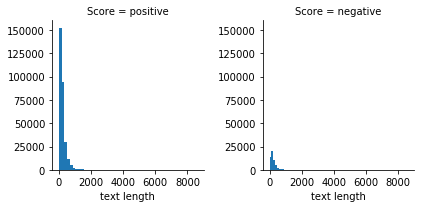

In [23]:
import seaborn as sns
g = sns.FacetGrid(data = b , col = 'Score')
g.map(plt.hist , 'text length' , bins = 50)
plt.show()

In [63]:
sns.boxplot(x='Score', y='text length', data=b)

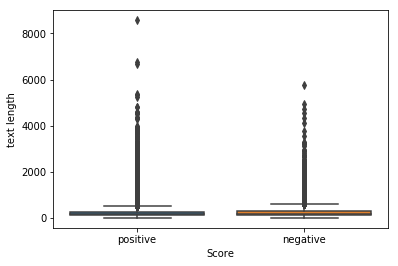

In [64]:
plt.show()

### Function for standardizing data

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:

def std_data(matrix):
    scaler  = StandardScaler(with_mean=False)
    scaler.fit(matrix)
    return scaler.transform(matrix) 
 

In [27]:
# picking top 150k data points 
sampled_data = b.head(150000)

In [28]:
sampled_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


In [29]:
# splitting  data into train and test set
def response_label(sign):
    if sign == "positive":
        return 1                               # positive-----> 1
    else:
        return -1                              # negative-----> -1 
    
sampled_data["Score"] = sampled_data["Score"].map(response_label)
X_train, X_test, Y_train, Y_test , len_train , len_test  = train_test_split(sampled_data['CleanedText'],sampled_data['Score'], sampled_data['text length'],test_size=0.3, random_state=45)

In [30]:
Y_train.value_counts()

 1    90909
-1    14091
Name: Score, dtype: int64

## Bag of Words

In [31]:
#CountVectorizer()--> Converts a collection of text documents to a matrix of token counts

# Initialize a CountVectorizer object: count_vectorizer
count_vect = CountVectorizer(ngram_range = (1,3) , min_df = 50 , max_df = 0.7)

# Transforming train/test data into bag of words
bow_X_train_matrix = count_vect.fit_transform(X_train.values)
print( bow_X_train_matrix.shape)

bow_X_test_matrix = count_vect.transform(X_test.values)
print(bow_X_test_matrix.shape)

(105000, 12026)
(45000, 12026)


In [32]:
# feature engineering
# adding text length as a feature to the dataset
from scipy.sparse import hstack
bow_X_train_matrix = hstack((bow_X_train_matrix,np.array(len_train)[:,None]))
bow_X_test_matrix = hstack((bow_X_test_matrix,np.array(len_test)[:,None]))


### Cross Validation for hyperparameter(alpha) tunning


In [33]:
parameter = {"alpha":  np.array( [0.00001, 0.0001, 0.001, 0.01, 0.1,10,100 , 1000] )}

# since features has discrete values hence choosing MULTINOMIAL Navie Bayes
model = MultinomialNB() 

tscv = TimeSeriesSplit(n_splits=10).split(bow_X_train_matrix , Y_train)
clf = GridSearchCV(model, parameter, cv = tscv,scoring='f1')

In [34]:
clf.fit(bow_X_train_matrix , Y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000228A7D1CA98>,
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [35]:
# checking cross validation accuracy for each alpha
cv_score = list(clf.cv_results_.get('mean_test_score'))
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1,10,100 , 1000]
for i in range(len(cv_score)):
    print('f1_score for alpha = ',alpha_values[i],'is ',cv_score[i] )

f1_score for alpha =  1e-05 is  0.9531058204372995
f1_score for alpha =  0.0001 is  0.9535705681503686
f1_score for alpha =  0.001 is  0.9542622594678438
f1_score for alpha =  0.01 is  0.9548217277820975
f1_score for alpha =  0.1 is  0.9546789302010594
f1_score for alpha =  10 is  0.9511830460513625
f1_score for alpha =  100 is  0.9277208977685663
f1_score for alpha =  1000 is  0.9277000491563847


In [36]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

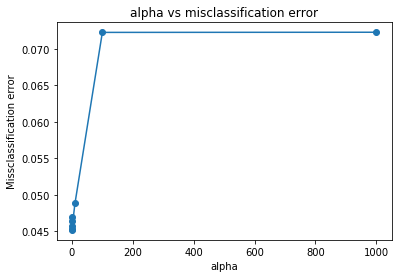

In [38]:
# plot
acc_score= clf.cv_results_.get('mean_test_score')
error = [1-x for x in acc_score]
alpha = np.array( [0.00001, 0.0001, 0.001, 0.01, 0.1,10 , 100 , 1000] )
plt.plot(alpha,error , 'o-')
plt.xlabel('alpha')
plt.ylabel('Missclassification error')
plt.title('alpha vs misclassification error')
plt.show()

In [39]:
# best value of alpha for model
clf.best_params_

{'alpha': 0.01}

In [41]:
#  model training
clf_BOW = MultinomialNB(alpha = clf.best_params_['alpha'])
clf_BOW.fit(bow_X_train_matrix, Y_train)


MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

#### Test and Train accuracy

In [42]:
# test accuracy on trained model
test_prediction = clf_BOW.predict(bow_X_test_matrix)  # predicted output of test data
test_accuracy = accuracy_score(Y_test, test_prediction) * 100 
print('Test accuracy: %f%%'%(test_accuracy))


Test accuracy: 92.173333%


In [43]:
#  train accuracy
train_prediction = clf_BOW.predict(bow_X_train_matrix)  # predicted output of train data
train_accuracy = accuracy_score(Y_train, train_prediction) * 100 
print('Train accuracy: %f%%'%(train_accuracy))


Train accuracy: 92.846667%


### Performance Metrics

             precision    recall  f1-score   support

         -1       0.67      0.82      0.74      6149
          1       0.97      0.94      0.95     38851

avg / total       0.93      0.92      0.92     45000



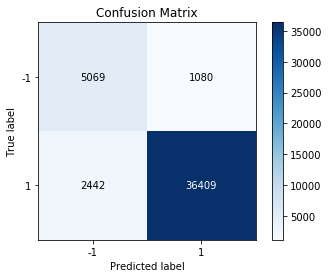

In [44]:
# using metrics like precision, recall f1-score and confusion matrix to evaluate performance of model
print(classification_report(Y_test, test_prediction))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

### Feature Importance

In [46]:
#Source:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(vectorizer, clf, n=50):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\tPostive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-20s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect , clf_BOW)

			Negative		Postive
________________________________________________________________________________________________
	-21.6314	total wast          		-6.3296	great          
	-15.9243	not recommend product		-6.3718	not            
	-15.9243	realli want like    		-6.4049	good           
	-15.6375	worst tast          		-6.4058	tast           
	-15.4148	zero star           		-6.4250	like           
	-15.2328	big disappoint      		-6.5290	love           
	-15.2328	not worth money     		-6.5946	flavor         
	-15.2328	two star            		-6.6080	tea            
	-15.0789	extrem disappoint   		-6.7581	use            
	-15.0789	refund money        		-6.7633	product        
	-14.9456	not worth price     		-6.7951	one            
	-14.8279	avoid product       		-6.8801	coffe          
	-14.8279	not buy product     		-6.9014	tri            
	-14.7227	fals advertis       		-6.9995	best           
	-14.7227	money back          		-7.0021	make           
	-14.7227	one worst           		-7.1023	g

# TF-IDF

In [47]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3) , min_df = 50 , max_df = 0.7)
# Transforming train/test data into tf-idf
tf_idf_X_train_matrix = tf_idf_vect.fit_transform(X_train.values)
print(tf_idf_X_train_matrix.shape)
tf_idf_X_test_matrix = tf_idf_vect.transform(X_test.values)
print(tf_idf_X_test_matrix.shape)

(105000, 12026)
(45000, 12026)


In [48]:
#addling length as feature
tf_idf_X_train_matrix = hstack((tf_idf_X_train_matrix,np.array(len_train)[:,None]))
tf_idf_X_test_matrix = hstack((tf_idf_X_test_matrix,np.array(len_test)[:,None]))


### Cross Validation

In [49]:
# cross validation to find best alpha using grid search
parameter = {"alpha":  np.array( [0.00001, 0.0001, 0.001, 0.01, 0.1,10,100] )}
model = MultinomialNB()
tscv = TimeSeriesSplit(n_splits=10).split(tf_idf_X_train_matrix , Y_train)
clf2 = GridSearchCV(model, parameter, cv = tscv,scoring='f1')

In [50]:
clf2.fit(tf_idf_X_train_matrix , Y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x00000228BD981DB0>,
       error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [51]:
# checking cross validation accuracy for each alpha
cv_score = list(clf2.cv_results_.get('mean_test_score'))
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1,10,100 , 1000]
for i in range(len(cv_score)):
    print('f1_score for alpha = ',alpha_values[i],'is ',cv_score[i] )

f1_score for alpha =  1e-05 is  0.9503185657473112
f1_score for alpha =  0.0001 is  0.9505842872064835
f1_score for alpha =  0.001 is  0.9511225709507862
f1_score for alpha =  0.01 is  0.9519651666146532
f1_score for alpha =  0.1 is  0.9530441381603616
f1_score for alpha =  10 is  0.9280592118563553
f1_score for alpha =  100 is  0.9277000491563847


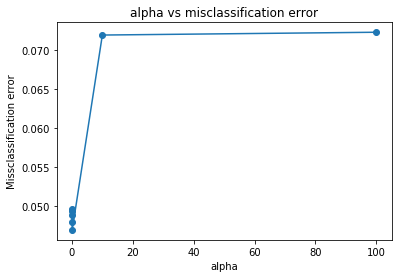

In [52]:
# plot
acc_score= clf2.cv_results_.get('mean_test_score')
error = [1-x for x in acc_score]
alpha = np.array( [0.00001, 0.0001, 0.001, 0.01, 0.1,10 , 100] )
plt.plot(alpha,error , 'o-')
plt.xlabel('alpha')
plt.ylabel('Missclassification error')
plt.title('alpha vs misclassification error')
plt.show()

In [53]:
# best parameter
clf2.best_params_

{'alpha': 0.1}

In [54]:
clf2.best_score_

0.9530441381603616

In [55]:
#training
clf_tfIdf = MultinomialNB(alpha = clf2.best_params_['alpha'])
clf_tfIdf.fit(tf_idf_X_train_matrix, Y_train)


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

### Train and Test accuracy

In [56]:
# test accuracy on trained model
test_prediction_tfIdf = clf_tfIdf.predict(tf_idf_X_test_matrix)  # predicted output of test data
test_accuracy_tfIdf = accuracy_score(Y_test, test_prediction_tfIdf) * 100 
print('Test accuracy: %f%%'%(test_accuracy_tfIdf))

Test accuracy: 91.828889%


In [57]:
#train accuracy
train_prediction_tfIdf = clf_tfIdf.predict(tf_idf_X_train_matrix)  # predicted output of train data
train_accuracy_tfIdf = accuracy_score(Y_train, train_prediction_tfIdf) * 100 
print('Train accuracy: %f%%'%(train_accuracy_tfIdf))

Train accuracy: 92.525714%


### Performance Metrics

             precision    recall  f1-score   support

         -1       0.87      0.47      0.61      6149
          1       0.92      0.99      0.95     38851

avg / total       0.91      0.92      0.91     45000



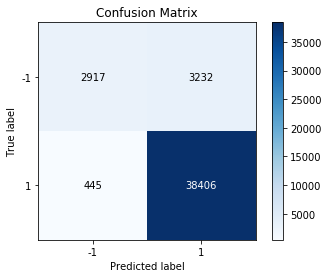

In [58]:
print(classification_report(Y_test, test_prediction_tfIdf))
import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction_tfIdf)
plt.show()

In [59]:
        
show_most_informative_features(tf_idf_vect , clf_tfIdf)

			Negative		Postive
________________________________________________________________________________________________
	-19.1630	total wast          		-8.9870	great          
	-17.7779	realli want like    		-9.1045	tea            
	-17.4623	not recommend product		-9.1242	good           
	-17.4575	worst tast          		-9.1367	love           
	-17.0628	zero star           		-9.2278	tast           
	-16.8946	two star            		-9.2936	like           
	-16.8145	not worth money     		-9.3082	coffe          
	-16.6867	extrem disappoint   		-9.3276	flavor         
	-16.6597	big disappoint      		-9.3344	not            
	-16.5674	refund money        		-9.3743	product        
	-16.5065	avoid product       		-9.4637	best           
	-16.4790	money back          		-9.4702	use            
	-16.3830	not worth price     		-9.5534	one            
	-16.3651	not buy product     		-9.6226	tri            
	-16.3251	fals advertis       		-9.6628	make           
	-16.3109	one worst           		-9.7427	g

### Results

In [61]:
from prettytable import PrettyTable
x = PrettyTable()

In [62]:
x.field_names = ["Model", "Hyperparameter", "Test accuracy", "Train accuracy" , "f1-score"]
x.add_row(['NB with BOW' , '0.01' , '92.17' , '92.84' , '0.92'])
x.add_row(['NB with TfIdf' , '0.1' , '91.88' , '92.52' , '0.91'])
print(x)

+---------------+----------------+---------------+----------------+----------+
|     Model     | Hyperparameter | Test accuracy | Train accuracy | f1-score |
+---------------+----------------+---------------+----------------+----------+
|  NB with BOW  |      0.01      |     92.17     |     92.84      |   0.92   |
| NB with TfIdf |      0.1       |     91.88     |     92.52      |   0.91   |
+---------------+----------------+---------------+----------------+----------+


### Conclusion
1. Naive bayes is a good algorithm for text based classifications.
2. the algorithm is fast, both the training and testing time was considerably lesser than other algorithms like kNN.
3. performance of the model is good on both seen and unseen data.
4. Since naive bayes assumes features to be independent of each other hence vectorization techniques like wrod2vec and tf-Idf    word2vec doesn't work well with naive bayes as w2vec features are dependent.

 